### This notebook needs to be put inside driver folder

In [ ]:
# need to install these (Check the python version in previous step)
#! sudo python3 -m pip install bitstring
#! sudo python3 -m pip install -e git+https://github.com/fbcotter/dataset_loading#egg=dataset_loading
! sudo python3 -m pip install torch==1.11.0
! sudo python3 -m pip install torchvision==0.1.6
! sudo python3 -m pip install numpy==1.24.1
!pip freeze | grep numpy

In [1]:
# Includes
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
from driver import io_shape_dict
from driver_base import FINNExampleOverlay

In [2]:
# Setting the parameters for platform
bsize = 4 # taking batch size of 4 for test
dataset = "cifar10"
bitfile = "../bitfile/finn-accel.bit"
platform = "zynq-iodma"
dataset_root = "./dataset"

In [3]:
# Loading the desired dataset (in our case it is cifar10)
if dataset == "mnist":
    from dataset_loading import mnist

    trainx, trainy, testx, testy, valx, valy = mnist.load_mnist_data(
    dataset_root, download=True, one_hot=False
    )
elif dataset == "cifar10":
    from dataset_loading import cifar

    trainx, trainy, testx, testy, valx, valy = cifar.load_cifar_data(
    dataset_root, download=True, one_hot=False
    )
else:
    raise Exception("Unrecognized dataset")

Tar File found in dest_dir. Not Downloading again
Extracting Python CIFAR10 data.
Files extracted


In [4]:
# Driver to access our accelerator (basically an API to access hardware overlay of our accelerator)
driver = FINNExampleOverlay(
        bitfile_name=bitfile,
        platform=platform,
        io_shape_dict=io_shape_dict,
        batch_size=bsize,
        runtime_weight_dir="runtime_weights/",
    )

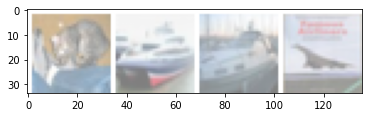

GroundTruth:  cat     ship    ship    plane  
Predictions:  cat     ship    truck   ship   


In [38]:
# function to display images
def imshow(img):
    npimg = img.numpy()
    npimg = npimg / 255
    npimg = npimg / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# loading the test images and labels into variables 
test_imgs = testx
test_labels = testy

# Need to change the channel dimension to be the 2nd dimension for display (no of images x channels x Height x Width)
display_imgs = np.moveaxis(testx, [3], [1])

# need to reshape test image, display image and labels a bit
total = 10000
n_batches = int(total / bsize)
test_imgs = test_imgs.reshape(n_batches, bsize, -1)
display_imgs = display_imgs.reshape(n_batches, bsize, -1)
test_labels = test_labels.reshape(n_batches, bsize)

# Defining the classes which need to be classified
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Batch number to load first 4 images and their labels
batch_idx = 0

# Preparing display image and ground truth for display
display_imgs = display_imgs[batch_idx].reshape(4, 3, 32, 32)
ground_truth = test_labels[batch_idx]

# Displaying the image
imshow(torchvision.utils.make_grid(torch.tensor(display_imgs.astype('float'))))

# Print ground truth
print('GroundTruth: ', ' '.join(f'{classes[ground_truth[j]]:7s}' for j in range(bsize)))

# Get the predictions via inference
ibuf_normal = test_imgs[batch_idx].reshape(driver.ibuf_packed_device[0].shape) # reshape the input for driver
driver.copy_input_data_to_device(ibuf_normal) # copy input to data buffers of the accelerator
driver.execute_on_buffers() # executing the accelerator
obuf_normal = np.empty_like(driver.obuf_packed_device[0]) # creating an empty nparray to copy output with driver output shape  
driver.copy_output_data_from_device(obuf_normal) # copy output to this empty nparray
print('Predictions: ', ' '.join(f'{classes[obuf_normal.flatten()[j]]:7s}' for j in range(bsize))) # output needs to be flattened

In [39]:
# Now running the validation script to measure the accuracy and time taken in inference
! python3 ./validate.py --batchsize 1000 --dataset cifar10 --bitfile ../bitfile/finn-accel.bit --dataset_root ./dataset

Tar File found in dest_dir. Not Downloading again
Extracting Python CIFAR10 data.
Files extracted
Inference Time :  2.2042126655578613 seconds
Final accuracy: 51.800000
